# Quantum Key Distribution
### BB-84

* In 1984, building on the work of Wiesner, Charles Bennett, an IBM's researcher, and Gilles Brassard, of the Université de Montréal, developed the first quantum cryptographic protocol, which goes under the codename of BB84.
* The goal of the BB84 protocol is to create a secret key between two parties, Alice and Bob, that can then be used by both parties to encrypt and decrypt a hidden message. 

## BB84 protocol

Let's walk through the steps of the BB84 protocol:

1. In the first step, Alice chooses two random bit strings, $k$ and $b$, that each consist of $n$ bits. Her bit string $k$ contains the actual bits she wants to encode (out of which the key will later be formed), while $b$ determines the bases in which she will encode her bits. For $b_i=0$ (i.e., if the $i^{th}$ bit is zero), she encodes the $i^{th}$ qubit in the standard $\{|0\rangle, |1\rangle \}$ basis, while for $b_i=1$, she encodes it in the $\{|+\rangle, |-\rangle \}$ basis, where $|+\rangle:=\frac{1}{\sqrt{2}}(|0\rangle +|1\rangle)$, $|-\rangle:=\frac{1}{\sqrt{2}}(|0\rangle -|1\rangle)$. 
This becomes more illustrative when representing each basis by two perpendicular arrows, where the two different bases are rotated by $45^\circ$.
The encoding of each qubit $q_i$ would therefore look like the following:

<center>
<img src="img/encoding_Alice.png" alt="drawing" width="300"/>
</center>


2. After encoding her $n$ qubits, Alice sends these qubits to Bob. Bob also chooses a random bit string $\tilde{b}$ consisting of $n$ bits that determines in which bases he is going to perform measurements. He stores the outcomes of his measurements $\tilde{k_i}$ together with the corresponding basis bits $\tilde{b_i}$ in a table.

3. Next, Alice and Bob compare their basis bits $b_i$ and $\tilde{b}_i$. Whenever $b_i \neq \tilde{b}_i$, Bob measured in a different basis than Alice's qubit was encoded in, so he gets each outcome with probability $\frac{1}{2}$. Alice and Bob therefore discard all key bits corresponding to these basis bits. If $b_i = \tilde{b}_i$, however, they prepared and measured the qubit in the same basis, so (unless someone eavesdropped) Bob will get the key bit that Alice encoded, $\tilde{k}_i = k_i$. These outcomes then compose the key.

## An illustrated example

Suppose Alice's random bit strings are $k=`0111001`$ and $b=`1101000`$ and Bob's random bit string is $\tilde{b}=`1001101`$. Try to understand the other entries in the table below. Note that in the case where the basis bits are different, Bob has a 50% chance to get each outcome, so here one of them was chosen randomly.

<center>
<img src="img/example_bb84.png" alt="drawing" width="600"/>
</center>

The key produced in this example would be '0110'. To make sure that the key is secret and correct, Alice and Bob would "sacrifice" some of their key bits to check that no one eavesdropped. If someone had measured a qubit on the way, this could have changed the state of that qubit and with probability $\frac{1}{4}$, Bob's and Alice's key bits will be different. By checking $m$ bits, the probability to not notice an eavesdropper decreases as $\left(\frac{3}{4}\right)^m$. Thus, if they check enough bits and they are all the same, they can assume that no one eavesdropped and their key is secret.

### Message encrpytion
Once a secret key is distributed, Alice can encrypt her message by using the so-called [one-time pad](https://en.wikipedia.org/wiki/One-time_pad) technique: she simply adds the key bits on top of her secret message bits that she wants to send. Using the example above, her key is $\text{key}=`0110`$. If her secret message bit string is $m=`1100`$, the encrypted message will be $c=m\oplus \text{key} \mod 2 = `1010`$. Bob can then decrypt the message by adding his key on that encrypted message, $m=c\oplus \text{key} \mod 2$.

# How it works - Practical Approach
Here's the big question: how are we going to get your key to Bob without eavesdroppers intercepting it? 

1. You (Alice) generate a random string--the key you wish to give to Bob.
2. You (Alice) convert your string bits into corresponding qubits.
3. You (Alice) send those qubits to Bob, BUT! you randomly rotate some into a superposition. This effectively turns your key into random noise. (This is good because your lurking enemies might measure your qubits.)
4. Bob receives yours qubits AND randomly rotates some qubits in the opposite direction before measuring.
5. Alice and Bob publicly share which qubits they rotated. When they both did the same thing (either both did nothing or both rotated), they know the original key bit value made it to Bob! (Overall, you can see that only some of the bits from Alice's original key should make it.)
6. Alice and Bob create their keys. Alice modifies her original key by keeping only the bits that she knows made it to Bob. Bob does the same.


Alice and Bob now have matching keys! They can now use this key to encrypt and decrypt their messages.

<img src="img/BB84_schema.png"
     alt="courier" />

## Quantum Key Distribution: Proof of concept on a quantum  computer
*Modified from: [qiskit community tutorial - deprecated](https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/awards/teach_me_qiskit_2018/cryptography/Cryptography.ipynb)*

Next we do some preliminary settings to better manipulate quantum circuits and we set the number of available qubits to 16

In [14]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, qasm2
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_histogram
import numpy as np

In [15]:
# Creating registers with n qubits
n = 16  
qr = QuantumRegister(n, name='qr')
cr = ClassicalRegister(n, name='cr')

We create Alice's quantum circuit, made of $n$ qubits (and $n$ bits in a classical register, for measuring). We use $randint$ from numpy to generate a random number in the available range which will be our key and then we write the resulted number in binary and we memorize the key in a proper variable

In [16]:
# Quantum circuit for alice state
alice = QuantumCircuit(qr, cr, name='Alice')
# Generate a random number in the range of available qubits [0,65536))
alice_key = np.random.randint(0, high=2**n)
# Cast key to binary for encoding
# range: key[0]-key[15] with key[15] least significant fi``gure
alice_key = np.binary_repr(alice_key, n) # n is the width

Parse the generated key and we encode it in Alice's circuit, initializing her qubits to the computational basis: $\{\lvert 0 \rangle,\  \lvert 1 \rangle\}$, according to the value bit. Then we apply a rotation to about half of these qubits, so that about $1/2$ of them will now be in one of the eigenstates of the diagonal basis:  $\{\lvert \nearrow \rangle,\  \lvert \searrow \rangle\}$. We record the basis choice in a list (table) that will later be used for key verification.

In [17]:
# Encode key as alice qubits 
for index, digit in enumerate(alice_key):
    if digit == '1':
        alice.x(qr[index]) # if key has a '1', change state to |1>
        
# Switch randomly about half qubits to diagonal basis
alice_table = []        # Create empty basis table
for index in range(len(qr)):       
    if 0.5 < np.random.random():   # With 50% chance...
        alice.h(qr[index])         # ...change to diagonal basis
        alice_table.append('X')    # character for diagonal basis
    else:
        alice_table.append('Z')    # character for computational basis

How can we send this state to Bob? As said, we don't have another quantum computer, but we can create another quantum circuit, which we call $bob$, and initialize Bob's initial state to Alice's output state. To accomplish this task we define a helper function, *SendState*, that retrieves the qasm code of a given quantum circuit, $qc1$, does some filtering to extract the quantum gates applied, and produces new instructions that uses to initialize another circuit, $qc2$. This trick works because QISKit maintains a python dictionary of quantum circuits with their relative qasm instructions.

In [18]:
def SendState(qc1, qc2, qc1_name):
    ''' This function takes the output of a circuit qc1 (made up only of x and 
        h gates and initializes another circuit qc2 with the same state
    ''' 
    
    # Quantum state is retrieved from qasm code of qc1
    qs = qasm2.dumps(qc1).split(sep=';')[4:-1]
    # qs = qc1.qasm().split(sep=';')[4:-1]

    # Process the code to get the instructions
    for index, instruction in enumerate(qs):
        qs[index] = instruction.lstrip()

    # Parse the instructions and apply to new circuit
    for instruction in qs:
        if instruction[0] == 'x':
            old_qr = int(instruction[5:-1])
            qc2.x(qr[old_qr])
        elif instruction[0] == 'h':
            old_qr = int(instruction[5:-1])
            qc2.h(qr[old_qr])
        elif instruction[0] == 'm': # exclude measuring:
            pass
        else:
            raise Exception('Unable to parse instruction')

Now we can create Bob's circuit and "send" Alice's qubits to Bob. We pretend that this state is unknown to Bob so that he doesn't know which basis to use and decides randomly that $1/2$ of the qubits are to be measured in the rectilinear basis and the other $1/2$ in the diagonal basis; we then record Bob's choice in his table list variable 

In [25]:
bob = QuantumCircuit(qr, cr, name='Bob')

SendState(alice, bob, 'Alice')    

# Bob doesn't know which basis to use
bob_table = []
for index in range(len(qr)): 
    if 0.5 < np.random.random():  # With 50% chance...
        bob.h(qr[index])        # ...change to diagonal basis
        bob_table.append('X')
    else:
        bob_table.append('Z')

Bob can now go ahead and measure all his qubits and store the measurement in the classical register. Note that is very important that $shots=1$, since we have to pretend that Bob has only one measurement chance, otherwise he could statistically infer the basis used (you can try). 

In [20]:
# Measure all qubits
for index in range(len(qr)): 
    bob.measure(qr[index], cr[index])

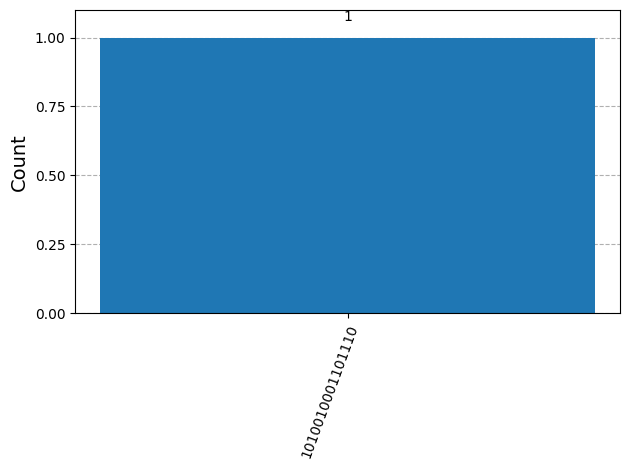

In [21]:
# Execute the quantum circuit 
result = QasmSimulator().run(bob, shots=1).result()
plot_histogram(result.get_counts())

In [22]:
# Result of the measure is Bob's key candidate
bob_key = list(result.get_counts(bob))[0]
bob_key = bob_key[::-1]      # key is reversed so that first qubit is the first element of the list

The histogram is not highly informative of course, but we can see that the measure has been performed correctly. Alice and Bob can switch over to the classical channel, compare their basis table lists, and discard qubits measured using different basis.

In [23]:
keep = []
discard = []
for qubit, basis in enumerate(zip(alice_table, bob_table)):
    if basis[0] == basis[1]:
        print("Same choice for qubit: {}, basis: {}" .format(qubit, basis[0])) 
        keep.append(qubit)
    else:
        print("Different choice for qubit: {}, Alice has {}, Bob has {}" .format(qubit, basis[0], basis[1]))
        discard.append(qubit)

Same choice for qubit: 0, basis: X
Same choice for qubit: 1, basis: X
Different choice for qubit: 2, Alice has Z, Bob has X
Different choice for qubit: 3, Alice has X, Bob has Z
Same choice for qubit: 4, basis: Z
Different choice for qubit: 5, Alice has Z, Bob has X
Same choice for qubit: 6, basis: Z
Same choice for qubit: 7, basis: X
Same choice for qubit: 8, basis: Z
Different choice for qubit: 9, Alice has Z, Bob has X
Different choice for qubit: 10, Alice has X, Bob has Z
Different choice for qubit: 11, Alice has X, Bob has Z
Same choice for qubit: 12, basis: X
Same choice for qubit: 13, basis: Z
Same choice for qubit: 14, basis: X
Same choice for qubit: 15, basis: X


We know that Bob will pick the wrong basis for $1/2$ of the qubits, so we can check that this theoretical probability is indeed replicated. We also know that although Bob picks the wrong basis, he can still end up with right eigenstate, and that he will do so about $1/2$ of the times, getting right $3/4$ of the qubits. We can check when Alice's and Bob's measurements coincide due to pure chance, although noting that this step is never performed in the actual key sharing step, but only in the inital sharing to test for eavesdropper.

In [26]:
acc = 0
for bit in zip(alice_key, bob_key):
    if bit[0] == bit[1]:
        acc += 1

print('Percentage of qubits to be discarded according to table comparison: ', len(keep)/n)
print('Measurement convergence by additional chance: ', acc/n)                

Percentage of qubits to be discarded according to table comparison:  0.625
Measurement convergence by additional chance:  0.8125


Now before sifting the keys we perform a check on a certain number of the qubits, comparing their value to see if they have been altered. Since we have only 16 qubits, which is a really low number, we check all of them. Although the procedure is limited to exchange 16 qubits at a time it can be repeated as many times as needed.

In [27]:
new_alice_key = [alice_key[qubit] for qubit in keep]
new_bob_key = [bob_key[qubit] for qubit in keep]

acc = 0
for bit in zip(new_alice_key, new_bob_key):
    if bit[0] == bit[1]:
        acc += 1        
        
print('Percentage of similarity between the keys: ', acc/len(new_alice_key))              

Percentage of similarity between the keys:  1.0


If the qubits measured are the same can accept the new sifted keys. The new sifted keys are printed to stdout, of course this step is just to verify the rightness of the protocol, when the procedure is repeated, each party is not supposed to know the other's sifted key. 

Note that, in the real world, quantum channel are subject to information loss since detectors are not perfectly efficient and some photons are going to be lost along the way. Thus, the similarity between the keys will hardly be $1.0$, but surely not as low as $0.75$ which we know is the case in which it has been eavesdropped. As a percentage cut-off we can pick $0.9$ and perform a check before calling the exchange successfull or invalid. You can try to insert a parameter that represents this loss as exercise. 

In [28]:
if (acc//len(new_alice_key) == 1):
    print("Key exchange has been successfull")
    print("New Alice's key: ", new_alice_key)
    print("New Bob's key: ", new_bob_key)
else:
    print("Key exchange has been tampered! Check for eavesdropper or try again")
    print("New Alice's key is invalid: ", new_alice_key)
    print("New Bob's key is invalid: ", new_bob_key)

Key exchange has been successfull
New Alice's key:  ['0', '1', '0', '1', '0', '0', '0', '1', '0', '1']
New Bob's key:  ['0', '1', '0', '1', '0', '0', '0', '1', '0', '1']


Everything overlaps perfectly, that is indeed almost trivial. It's time to introduce Eve, the eavesdropper, and see what happens. We create Eve's circuit and we initiliaze it to Alice's state. 

In [29]:
eve = QuantumCircuit(qr, cr, name='Eve')
SendState(alice, eve, 'Alice')   

Just like Bob, Eve doesn't know which basis to use and she picks them randomly while recording her choice in a (table) list

In [30]:
eve_table = []
for index in range(len(qr)): 
    if 0.5 < np.random.random(): 
        eve.h(qr[index])        
        eve_table.append('X')
    else:
        eve_table.append('Z')

She measures according to her basis choice and she generates her candidate key

In [31]:
for index in range(len(qr)): 
    eve.measure(qr[index], cr[index])
    
# Execute (build and run) the quantum circuit    
result = QasmSimulator().run(eve, shots=1).result()

# Result of the measure is Eve's key
eve_key = list(result.get_counts(eve))[0]
eve_key = eve_key[::-1]


Up to now, Eve did exactly what Bob did in the previous example. From this point on, however, things are a bit tricky. Eve has measured the state causing qubits to collapse in different eigenstates. This property is not easy to implement in QISKit because measurement results are stored in classical registered, while the qubits themselves are "unchanged". Therefore we need to update Eve's qubits to the new altered states starting from the results of the measures (Eve's key), reversing the instructions that Eve has executed, and apply them to qubits when necessary, which means when the basis choice was different.

You can try figure out yourself how a state is changed after a measurement, but remember that unitary operators in general don't commute.

In [32]:
# Update states to new eigenstates (of wrongly chosen basis)
for qubit, basis in enumerate(zip(alice_table, eve_table)):
    if basis[0] == basis[1]:
        print("Same choice for qubit: {}, basis: {}" .format(qubit, basis[0]))
    else:
        print("Different choice for qubit: {}, Alice has {}, Eve has {}" .format(qubit, basis[0], basis[1]))
        if eve_key[qubit] == alice_key[qubit]:
            eve.h(qr[qubit])
        else:
            if basis[0] == 'X' and basis[1] == 'Z':
                eve.h(qr[qubit])
                eve.x(qr[qubit])
            else:
                eve.x(qr[qubit])
                eve.h(qr[qubit])

Same choice for qubit: 0, basis: X
Different choice for qubit: 1, Alice has X, Eve has Z
Same choice for qubit: 2, basis: Z
Different choice for qubit: 3, Alice has X, Eve has Z
Same choice for qubit: 4, basis: Z
Different choice for qubit: 5, Alice has Z, Eve has X
Different choice for qubit: 6, Alice has Z, Eve has X
Same choice for qubit: 7, basis: X
Same choice for qubit: 8, basis: Z
Different choice for qubit: 9, Alice has Z, Eve has X
Different choice for qubit: 10, Alice has X, Eve has Z
Different choice for qubit: 11, Alice has X, Eve has Z
Different choice for qubit: 12, Alice has X, Eve has Z
Different choice for qubit: 13, Alice has Z, Eve has X
Same choice for qubit: 14, basis: X
Same choice for qubit: 15, basis: X


Eve's altered state is now sent to Bob that performs the usual routine

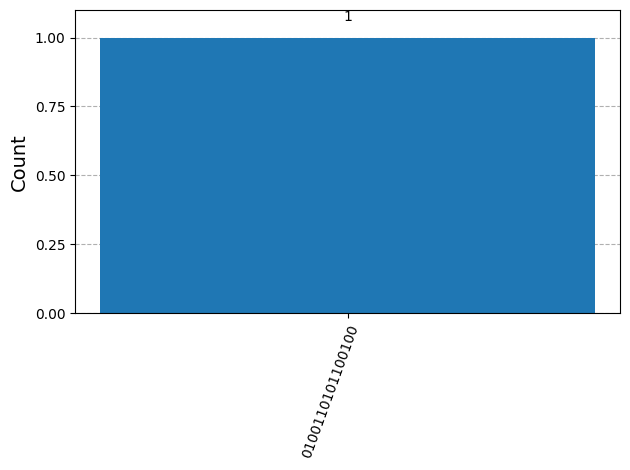

In [33]:
SendState(eve, bob, 'Eve')
          
bob_table = []
for index in range(len(qr)): 
    if 0.5 < np.random.random(): 
        bob.h(qr[index])      
        bob_table.append('X')
    else:
        bob_table.append('Z')
          
for index in range(len(qr)): 
    bob.measure(qr[index], cr[index])
          
result = QasmSimulator().run(bob, shots=1).result()
plot_histogram(result.get_counts(bob))






In [34]:
bob_key = list(result.get_counts(bob))[0]
bob_key = bob_key[::-1]

After the measure Alice and Bob share the basis table lists and perform the usual checks

In [35]:
keep = []
discard = []
for qubit, basis in enumerate(zip(alice_table, bob_table)):
    if basis[0] == basis[1]:
        print("Same choice for qubit: {}, basis: {}" .format(qubit, basis[0])) 
        keep.append(qubit)
    else:
        print("Different choice for qubit: {}, Alice has {}, Bob has {}" .format(qubit, basis[0], basis[1]))
        discard.append(qubit)
        
acc = 0
for bit in zip(alice_key, bob_key):
    if bit[0] == bit[1]:
        acc += 1

print('\nPercentage of qubits to be discarded according to table comparison: ', len(keep)/n)
print('Measurement convergence by additional chance: ', acc/n)  

new_alice_key = [alice_key[qubit] for qubit in keep]
new_bob_key = [bob_key[qubit] for qubit in keep]

acc = 0
for bit in zip(new_alice_key, new_bob_key):
    if bit[0] == bit[1]:
        acc += 1        
        
print('\nPercentage of similarity between the keys: ', acc/len(new_alice_key)) 

if (acc//len(new_alice_key) == 1):
    print("\nKey exchange has been successfull")
    print("New Alice's key: ", new_alice_key)
    print("New Bob's key: ", new_bob_key)
else:
    print("\nKey exchange has been tampered! Check for eavesdropper or try again")
    print("New Alice's key is invalid: ", new_alice_key)
    print("New Bob's key is invalid: ", new_bob_key)

Different choice for qubit: 0, Alice has X, Bob has Z
Same choice for qubit: 1, basis: X
Different choice for qubit: 2, Alice has Z, Bob has X
Different choice for qubit: 3, Alice has X, Bob has Z
Different choice for qubit: 4, Alice has Z, Bob has X
Same choice for qubit: 5, basis: Z
Same choice for qubit: 6, basis: Z
Different choice for qubit: 7, Alice has X, Bob has Z
Same choice for qubit: 8, basis: Z
Different choice for qubit: 9, Alice has Z, Bob has X
Same choice for qubit: 10, basis: X
Different choice for qubit: 11, Alice has X, Bob has Z
Same choice for qubit: 12, basis: X
Same choice for qubit: 13, basis: Z
Different choice for qubit: 14, Alice has X, Bob has Z
Different choice for qubit: 15, Alice has X, Bob has Z

Percentage of qubits to be discarded according to table comparison:  0.4375
Measurement convergence by additional chance:  0.5

Percentage of similarity between the keys:  0.42857142857142855

Key exchange has been tampered! Check for eavesdropper or try again
N

As you can see when Alice and Bob reveal their key to each other they notice a discordance: Eve has been caught!  To really get the percentages right, you can try repeating the experiment multiple times or you can write a higher routine that iterates the key sharing; in either case you will se that they converge to the expected values.